In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import time
import datetime
from sklearn import preprocessing
from sklearn import cluster, metrics

In [3]:
rscaler = preprocessing.RobustScaler()

In [4]:
df = pd.read_csv('df.csv')
df.shape

(5929, 7)

In [5]:
def feat_eng(x,dataf):
    #build the model x
    y = pd.DataFrame(index = x['customer_unique_id'].unique())

    #feature0  = number of order
    y['n_order'] = x.groupby('customer_unique_id').order_id.count()

    #feature1  = total value of orders
    #y['payment_total'] = x.groupby('customer_unique_id').order_total.agg('sum')

    #feature2-3  = mean and std of orders
    y['payment_mean'] = x.groupby('customer_unique_id').order_total.agg('mean')
    y['payment_std'] = x.groupby('customer_unique_id').order_total.agg('std')

    #feature frequency4-10 of order on the distrib
    x['order_dis'] = pd.cut(dataf['order_total'],30, duplicates = 'drop')
    temp = pd.crosstab(x['customer_unique_id'], x['order_dis'], values = x['order_dis'], aggfunc= 'count', margins = True)
    for i in range(temp.shape[1]):
        temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)

    temp = temp.drop(labels = 'All')
    temp = temp.drop(labels = 'All', axis = 1)
    y = y.join(temp)
    #feature frequency11-135 of category
    temp = pd.crosstab(x['customer_unique_id'], x['product_category_name'], values = x['product_category_name'], aggfunc= 'count', margins = True).fillna(0)
    for i in range(temp.shape[1]):
        temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)
    temp = temp.drop(labels = 'All')
    temp = temp.drop(labels = 'All', axis = 1)
    y = y.join(temp)

    #feature136-137 review score mean and std
    y['rev_mean'] = x.groupby('customer_unique_id').review_score.agg('mean')
    y['rev_std'] = x.groupby('customer_unique_id').review_score.agg('std')
    #feature138  = days since last order
    y['days_since_last_order'] = x.groupby('customer_unique_id').days_since_order.agg('min')
    #feature139 = "age" of the custumer
    y['age'] = x.groupby('customer_unique_id').days_since_order.agg('max')
    y = y.loc[y['n_order'] > 1]
    return y

In [6]:
def simulate(x):
    start = x['days_since_order'].max()
    end = x['days_since_order'].min()
    year = start - 365 #define a year
    t0 = x.loc[x['days_since_order'] > year ] #take only the first year customers
    t0 = feat_eng(t0,x) #feature enginering
    t0s = rscaler.fit_transform(t0.values)
    clus = cluster.KMeans(n_clusters = 30,random_state=38)
    clus.fit(t0s) # this is the T0 model Mt0
    ari_l = []
    year_n = year
    for i in range(int((year-end)/30)): #go for per month test
        tn = x.loc[x['days_since_order'] > year_n] # add a month of data
        tn = feat_eng(tn,x) # feature engineering on the the new data
        feat_diff = [x for x in list(t0.columns) + list(tn.columns) if x not in list(t0.columns) or x not in list(tn.columns)]
        if feat_diff:
            tn = tn.drop(labels = feat_diff, axis = 1) 
        tns = rscaler.fit_transform(tn.values)
        clus2 = cluster.KMeans(n_clusters =30,random_state=38) #this is the Tn model Mtn
        tn['pred_labels'] = clus2.fit_predict(tns) #predict Mt0(tn)
        tn['true_labels'] = clus.predict(tns) # predict Mtn(tn)
        ari_l.append(metrics.adjusted_rand_score(np.array(tn['true_labels']), np.array(tn['pred_labels']))) 
        year_n = year_n-30 #add another month
    return ari_l

In [7]:
simu = simulate(df)

In [9]:
np.full((1,10), 0.8)

array([[0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]])

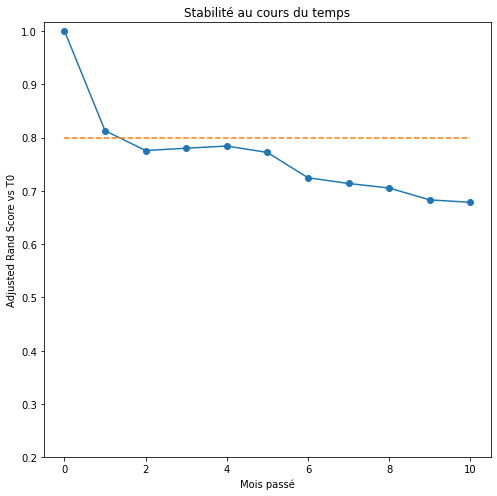

In [14]:
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(np.arange(0,len(simu),1), simu, marker ='o')
ax.plot(np.arange(0,len(simu),1), np.full((11), 0.8), linestyle ='--')
ax.set_ylim(bottom = 0.2)
ax.set_title('Stabilité au cours du temps')
ax.set_xlabel('Mois passé')
ax.set_ylabel('Adjusted Rand Score vs T0')
fig.savefig('stability.png', bbox_inches = 'tight')